<a href="https://colab.research.google.com/github/DanielMelo404/EMG-project/blob/main/Proyecto_EMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Analisis de señal de ECG
Por Daniel Melo Avila,  Rafel Ricardo Galindo y Diego Fernando Mejia
 

Este programa permite analizar y filtrar la señal de ECG para conocer los intervalos entre picos RQ, RT, RS y  QS, ademas de la frecucencia cardiaca, todos estos datos en funcion del tiempo.

La grafica de un latido medida se ve a continuacion. En esta, se pueden apreciar los picos principales, PQRST, y las distancias (tiempos) que los separan. Estos intervalos son caracteristicas de interes para los profesionales de la salud, los cuales pueden detectar patologias con base inspeccionar este diagrama. 

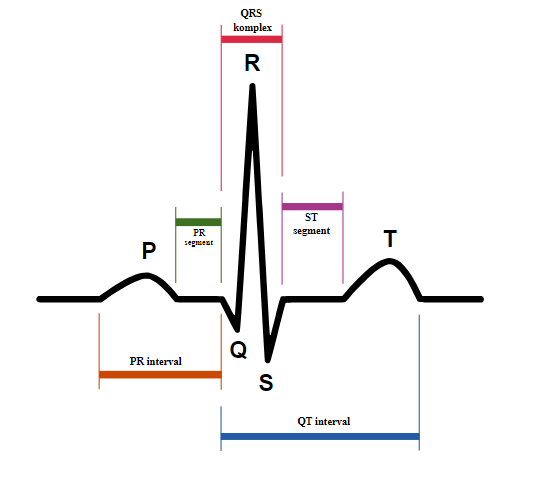

In [ ]:
import numpy as np
import math

tiPlot,tfPlot=[1,7]
perMuestreo = 0.01

def doWindow(x,t,tWindow,tStride,func,args): #x es el vector de datos sobre el que se hara lo que se valla a hacer con la ventana
  w = math.ceil(tWindow/perMuestreo)
  stride = math.ceil(tStride/perMuestreo)
  nWindows = math.floor((np.size(x)-w)/stride)#+1
  indexer = np.arange(w)[None, :] + stride*np.arange(nWindows)[:, None]
  windows = x[indexer]
  twindows = t[indexer]
  ts = np.array([]) #tiempos del arreglo t donde sucede el vento que busca la funcion func
  tsWindFunc = np.array([])

  for i in range(windows.shape[0]):
    # print(twindows[i,:])
    #Hacer que la funcion busque en la ventana los tiempos donde ocurre el evento
    if func.__name__ == 'encT':
     tsWindFunc = func(windows[i,:],twindows[i,:],0.15,0.15)
    elif func.__name__ == 'encRS':
     tsWindFunc, to = func(windows[i,:],twindows[i,:])
    elif func.__name__ == 'encQ':
     tR =  encRS(windows[i,:],twindows[i,:])# la idea es que tRs sea uno solo en la ventana, por esto, esta debe ser lo suficientmente pequeña
     if(tR!=-1):
      tsWindFunc = func(windows[i,:],twindows[i,:],tR,0.15, verifAltoQ)
    elif func.__name__ == 'enctiQ':
     tR =  encRS(windows[i,:],twindows[i,:])
     if(tR!=-1):
      tsWindFunc = func(windows[i,:],twindows[i,:],tR,0.15)
    elif func.__name__ == 'enctfS':
     xAux,tAux= args
     x2, t2  =ext(xAux,tAux,twindows[i,0],twindows[i,len(twindows[i,:])-1])
     tS =  encS(x2,t2)
    #  print(tS)
     if(tS!=-1):
      tsWindFunc = func(-1*windows[i,:],twindows[i,:],tS,0.1)
    elif func.__name__ == 'encS':
      tsWindFunc = func(windows[i,:],twindows[i,:])
      # print(tsWindFunc)
    elif func.__name__ == 'enctfT':
      tT = encT(windows[i,:],twindows[i,:],0.1,0.1)
      # tT =np.array([tT])
      if(tT.size>0):
        tT = tT[0]
      # tT = tT.reshape(tT,(1,))
      tder2 ,der2_10_ = derivar(windows[i,:],twindows[i,:],1)
      der10_ = windows[i,:]
      tder10_ = twindows[i,:]
      # der10, der2_10, tder10 = args
      if(tT!=-1):
        tsWindFunc = func(der10_,der2_10_,tder10_,tT,10)
    else:
      tsWindFunc = 1
    ts = np.append(ts,tsWindFunc)
    
  ts = np.unique(ts)
  tsIndex = np.array([])#Indices de los ts extraridos en el arreglo original t

  for i in range(len(ts)):
   tsIndex = np.append(tsIndex,np.where(t == ts[i])[0])
  
  tsIndex = tsIndex.astype(int)
  return tsIndex

def enctfS(x,t,tS,interv):
  # if(len(tR)>0):
  # t,x = moving_average(x,5,t)
  # #  tR_ = float(tR[0])+interv
  # t, x = derivar(x,t,1)
  # t,x = moving_average(x,1,t)
  # tR_ = float(tR)+interv
  tvar = encQ_(x,t,tS,interv,verifNegtiQ)
  # traba = 0
  # if (t[len(t)-1]<7)or traba==1:
  #   plt.plot(t,x)
  #   if(tvar.size == x[t==tvar].size):
  #     traba = 1
  #     plt.plot(tvar,x[t==tvar],marker='x',color="magenta",markersize = 30)
  
  # tvar = encQ(x,t,np.array([tR]),interv,verifNegtiQ)
  return tvar


def encQ(x,t,tR,intQ, func):#x es el vector con bajo filtrado que contiene a R, S y Q
  tR = tR[0]
  [x,t] = ext(x,t,tR-intQ,tR) #Se sabe que el Q solo puede estar dentro de un intervalo atras de tS, por eso se busca solo en esta zona
  [min,tmin] = encMin(x,t)
  if func(x,t,tR,tmin):#verificacion de condiciones para que sea un Q
    # plt.plot(t,x)
    # plt.plot(tmin,(x[tmin==t])[0],'x',markersize = 30)
    return tmin
  else:
    return -1

def encQ_(x,t,tR,intQ, func):#x es el vector con bajo filtrado que contiene a R, S y Q
  # tR = tR[0]
  # print(tR)
  [x,t] = ext(x,t,tR,tR+intQ) #Se sabe que el Q solo puede estar dentro de un intervalo atras de tS, por eso se busca solo en esta zona
  [min,tmin] = encMin(x,t)
  
  if func(x,t,tR,tmin):#verificacion de condiciones para que sea un Q
    # plt.plot(t,x)
    # plt.plot(tmin,(x[tmin==t])[0],'x',markersize = 30)
   return tmin
  else:
    return -1
    
#Para encontrar el inicio de los Q, se busca el minimo valor de la derivada 
#(esta sin filtrar) de la señal filtrada con un filtro de ventana de 5
def enctiQ(x,t,tR,interv):
  return encQ(x,t,tR,interv,verifNegtiQ)

def verifNegtiQ(x,t,tR,tmin):
  if(x[t==tmin]<0).all():
   return True
  return False
# def encQ(x,t,tR,intQ, func):#x es el vector con bajo filtrado que contiene a R, S y Q
#   tR = tR[0]
#   [x,t] = ext(x,t,tR-intQ,tR) #Se sabe que el Q solo puede estar dentro de un intervalo atras de tS, por eso se busca solo en esta zona
#   [min,tmin] = encMin(x,t)
#   if func(x,t,tR,tmin):#verificacion de condiciones para que sea un Q
#     return tmin
#   else:
#     return -1

def derivar(x,t,dt):
  xPlus1 = np.roll(x,1)
  der = -1*(xPlus1-x)/dt
  der[0]=0
  tf = t[len(t)-1]
  t = t-dt/2
  return  [t,der]
  
def moving_average(x, w, t):
  t= t[0+math.floor(w/2):len(t)-math.ceil(w/2)+1] #Recortar el vector de tiempo de x
  return [t, np.convolve(x, np.ones(w), 'valid') / w]
  
def ext(x,t,ti,tf):
  if(ti<tf):
    return[x[(t>ti)&(t<tf)], t[(t>ti)&(t<tf)]]
  else:
    return[x[(t>tf)&(t<ti)], t[(t>tf)&(t<ti)]]

def encMaxMin(x,t): #Encontrar maximo y minimo de datos x con tiempo t
  max = np.max(x)
  min = np.min(x)
  # t2segs = tiempo[tiempo<1]
  tmax = t[x==max]
  tmin = t[x==min]
  # tmax2segs = tiempo[]
  if(tmin.size == 2):
    tmin = tmin[0]
  return [max,tmax, min, tmin]

def verifAltoQ(x,t,tR,tmin):
  volR = x[t==tR]
  d = volR-min
  if(d>100)and(d<500):
    return True
  else:
    return False

def encMin(x,t):
  if(x.size>0):
    min = np.min(x)
    tmin = t[x==min]
    return [min,tmin]
  else:
    return [0,0]  
  
def encMax(x,t):
  if(x.size>0):
    max = np.max(x)
    tmin = t[x==max]
    return [max,tmax]
  else:
    return [0,0]  
    
def encS(x,t):
  to, tS = encRS(x,t)
  return tS

def encRS(x,t): #El vector x debe solo contener un latido y debe tener poco o nada de filtrado, t es el vector tiempo asociado
  [max,tmax, min, tmin] = encMaxMin(x,t)
  if (max-min)>200 and (tmax<tmin) and  (tmin-tmax)<0.1:
    tR = tmax
    tS = tmin
    return [tR, tS]
  else:
    return [-1,-1]

def encT(x,t,tNeg,tPos):
  tT = np.array([])
  # tT=np.array([]) #Pocibles tiempos del pico T
  tcambios, cambios = encCeros(x,t)
  tcambsNeg = t[cambios==-1]#Encontrar los cambios de positivo a negativo
  # print(tcambsNeg)
  for i in range(np.size(tcambsNeg)):
    if((x[(t<tcambsNeg[i]+tNeg)&(tcambsNeg[i]<t)]<0).all()) and ((x[(t>tcambsNeg[i]-tPos)&(tcambsNeg[i]>t)]>0).all()):
      tT = np.append(tT,tcambsNeg[i])
  return tT

def encCeros(x,t): 
  signos = np.sign(x)
  signosRoll1 = np.roll(signos,1)
  signos[signos == 0] = signosRoll1[signos==0]# esto es para cambiar los ceros por 1s o -1s, se pierden 10ms de presicion
  cambios = ((signosRoll1-signos)/-2) #Estos son los puntos en donde hay ceros, o cambios de signo
  cambios[0]  = 0
  tcambios = t[(cambios==-1)|(cambios==1)]
  return [tcambios, cambios]

def enctfT(der,der2,t,tT,casiCero):#Encontrar el final del pico T
  if (t>=tT+0.2).any():
    # print(der,der2)
    derAux = der[(t>tT)&(t<tT+0.2)]
    der2Aux = der2[(t>tT)&(t<tT+0.2)]
    # derAux = derAux[0:len(derAux)-1]
    tAux = t[(t>tT)&(t<tT+0.2)]
    tAux =  tAux[(derAux>-1*casiCero)&(der2Aux>0)]
    if tAux.size>0:
      return tAux[0]
    else:
      return -1
  else:
    return -1

## Importar la señal desde github

In [ ]:
df  = pd.read_csv('https://raw.githubusercontent.com/DanielMelo404/Proyecto-ECG/main/datalog.csv?token=GHSAT0AAAAAABVX7CJ7MM4IGTB2CFWMQSTCYVN5CFA')
# df  = pd.read_csv('https://raw.githubusercontent.com/DanielMelo404/Proyecto-ECG/main/datalog2.csv')
df.columns = ['Voltaje (V)']

## Grafica de la señal

(1.0, 7.0, 80.0, 670.0)

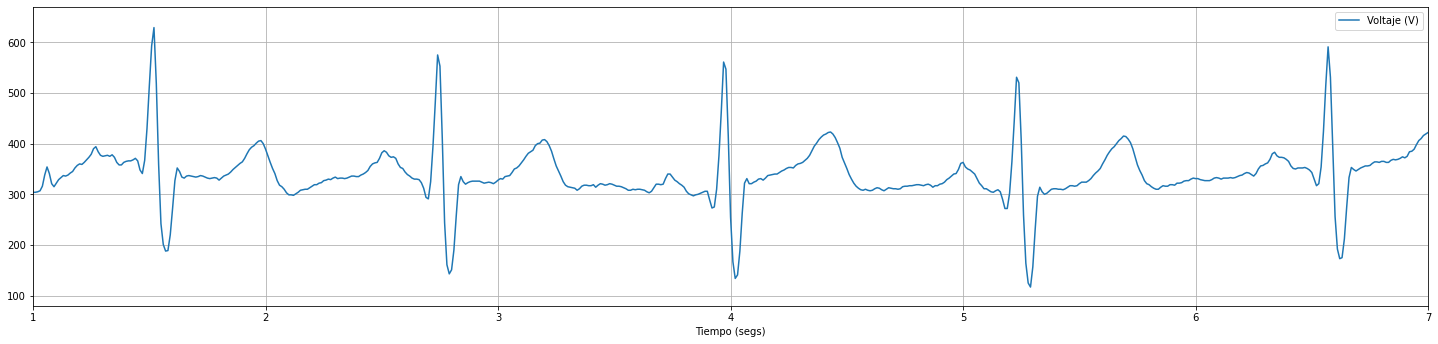

In [ ]:
plt.rcParams["figure.figsize"] = (25,5.5)
nMuestras = len(df)
samplingFrec = 100
perMuestreo = 1/samplingFrec
tiempo = perMuestreo*np.arange(nMuestras)
df['Tiempo (segs)'] = tiempo
df.plot(x="Tiempo (segs)",y = "Voltaje (V)")
plt.grid()
# tiPlot =10
# tfPlot = 12
plt.axis([tiPlot,tfPlot,80,670])

## Dividir el dataframe en arreglos numpy

In [ ]:
data = df.to_numpy()
d = np.array([data,[[0,0]]])
vol = data[:,0]
tiempo = data[:,1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


# Filtrar la señal

Quitar ruido de bajas recuencias y nivel de DC con filtro de ventana de 80

In [ ]:
w=80
[tFil80, volFil80] = moving_average(vol, w,tiempo)
vol=vol[0+math.floor(w/2):len(tiempo)-math.ceil(w/2)+1]
vol = vol[tiempo[0+math.floor(80/2):len(tiempo)-math.ceil(80/2)+1]==tFil80]-volFil80
tiempo = tiempo[0+math.floor(80/2):len(tiempo)-math.ceil(80/2)+1]


### Filtro 1
Filtro para identificacion de T, de ventana pequeña (w = ~9)

In [ ]:
w=12
[tfil1, volFil1] = moving_average(vol, w,tiempo)
t = tiempo[0:w-1]

Graficar señal filtrada

(1.0, 7.0, -200.0, 200.0)

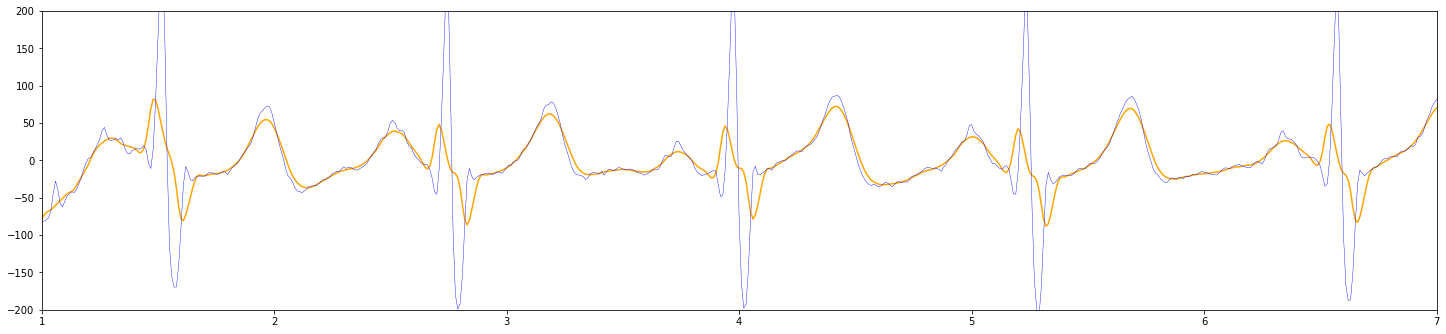

In [ ]:
plt.plot(tfil1,volFil1,color="orange")
plt.plot(t,200*np.ones(w-1),'r')
plt.plot(tiempo,vol,color="blue", linewidth=0.4)#Plotear de nuevo la original
plt.axis([tiPlot,tfPlot,-200,200])

## Filtro 2
Filtro de menor tamaño de ventana que filtro uno para captar a QRS

(1.0, 7.0, -200.0, 200.0)

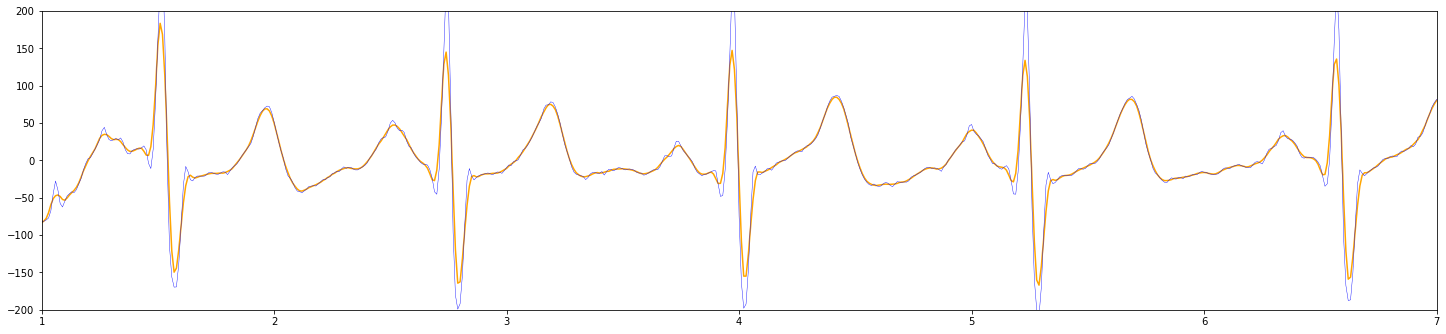

In [ ]:
w=5
[tFil2, volFil2] = moving_average(vol, w,tiempo)
t = tiempo[0:w-1]
plt.plot(tFil2,volFil2,color="orange")
plt.plot(t,200*np.ones(w-1),'r')
plt.plot(tiempo,vol,color="blue", linewidth=0.4)#Plotear de nuevo la original
plt.axis([tiPlot,tfPlot,-200,200])

En este punto se utilizan las señales filtradas y sus dervidas para conseguri caracterizar cada uno de los segmentos y puntos

In [ ]:
tder,der  = derivar(volFil1,tfil1,perMuestreo)
[tder10,der10]= moving_average(der,2,tder)
t2der,der2 = derivar(der10,tder10,perMuestreo)
t2der10, der2_10 = moving_average(der2,1,t2der)

# tderFil2,derVolFil2  = derivar(tFil2,volFil2,perMuestreo)
# [tderFil2,der10]= moving_average(der,5,tder)
# t2derFil2,der2Fil2 = derivar(der10,tder10,perMuestreo)
# t2der10, der2Fil2 = moving_average(der2,1,t2der)
# def derFil

(1.0, 7.0, -300.0, 300.0)

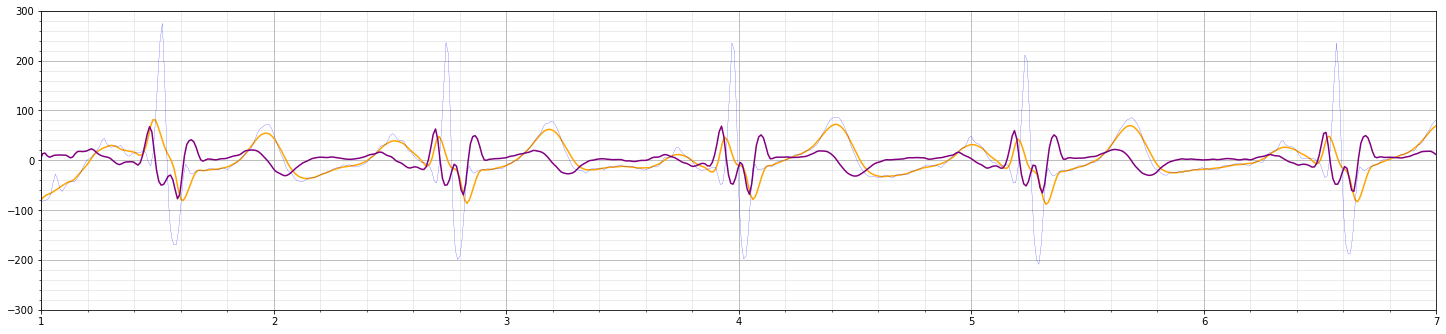

In [ ]:
up = 300
fig=plt.figure()
# plt.plot(tder,(der/50),color = "blue")
plt.plot(tfil1,volFil1,color="orange")

plt.plot(tder10,der10/30, color="purple")
plt.plot(tiempo,vol,color="blue", linewidth=0.2) #Plotear de nuevo la original
# plt.plot(t2der10,der2_10/300,color="green")
plt.grid(b=True, which='minor', linestyle='-', alpha=0.3)
plt.plot()
plt.minorticks_on()
plt.grid()
# tiPlot,tfPlot=[11.3,12.4]
plt.axis([tiPlot,tfPlot,-up,up])

# x,t = ext(vol,tiempo,tiPlot,tfPlot)
# tR, tS = encRS(x,t)
# tQ = encQ(x,t,tR,0.15)
# [x10,tfil1] =ext(der10,tder10,tS,tfPlot)
# tT = encT(x10,tfil1,0.08,0.08)
# tfT = enctfT(der10,der2_10,tder10,tT,100)
# plt.plot(np.array([tR,tS,tQ,tT]),np.array([x[tR==t],x[tS==t],x[tQ==t],x[tT+perMuestreo/2==t]]),'x',markersize=12,color='r')

2Da derivada

## Encontrar el pico mas alto

## Encontrar el pico T

Encontrar el final de los picos T

In [ ]:
tWindow = 1.5
tStride = 0.2
w=9
[tfil1_, volFil1_] = moving_average(vol, w,tiempo)
tder_,der_  = derivar(volFil1_,tfil1_,perMuestreo)
tfTsIndex =  doWindow(der_,tder_,tWindow,tStride,enctfT,0);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [ ]:
tWindow = 1.1
tStride = 0.2
tRsIndex = doWindow(vol,tiempo,tWindow, tStride, encRS,0)
tSsIndex = doWindow(vol,tiempo,tWindow,tStride,encS,0)
tfSsIndex = doWindow(der10,tder10,tWindow,tStride,enctfS,[vol,tiempo]);
# tWindow = 1.5
# tfTsIndex =  doWindow(der10,tder10,tWindow,tStride,enctfT,0);
tWindow =0.3
tQsIndex = doWindow(vol,tiempo,tWindow, tStride,encQ,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Encontrar el inicio de los Q

In [ ]:
tWindow = 1.5
w=9
[tfil1_, volFil1_] = moving_average(vol, w,tiempo)
tder_,der_  = derivar(volFil1_,tfil1_,perMuestreo)
tder_,der_= moving_average(der_,5,tder)
tiQsIndex = doWindow(der_,tder_,tWindow,tStride,enctiQ,0)#der 1
tTsIndex = doWindow(der_,tder_,tWindow, tStride,encT,0)#der 5

In [ ]:
w=5
[tfil1_, volFil1_] = moving_average(vol, w,tiempo)
tder_,der_  = derivar(volFil1_,tfil1_,perMuestreo)
tiQsIndex = doWindow(der_,tder_,tWindow,tStride,enctiQ,0)#der 1

(1.0, 7.0, -250.0, 300.0)

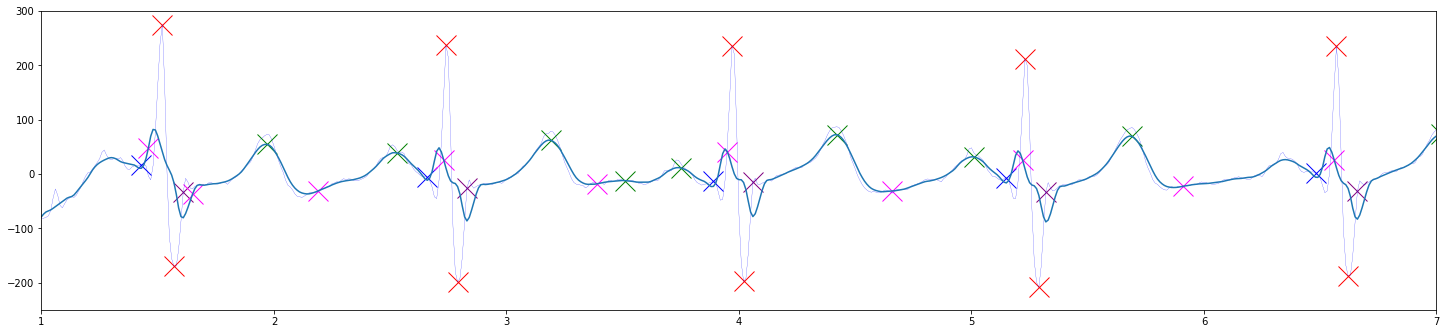

In [ ]:
#@title
plt.plot(tfil1[tTsIndex],volFil1[tTsIndex],'x',markersize = 20, color = "green");
plt.plot(tiempo[tRsIndex],vol[tRsIndex],'x',markersize = 20, color = 'r');
plt.plot(tiempo[tSsIndex],vol[tSsIndex],'x',markersize = 20, color = 'r');
plt.plot(tiempo[tQsIndex],vol[tQsIndex],'x',markersize = 20, color = "orange");
plt.plot(tiempo[tiQsIndex],vol[tiQsIndex],'x',markersize = 20, color = "blue");
tfSsIndex = tfSsIndex+3
tfTsIndex = tfTsIndex+3
plt.plot(tiempo[tfSsIndex],vol[tfSsIndex],'x',markersize = 20, color = "purple");
plt.plot(tfil1[tfTsIndex],volFil1[tfTsIndex],'x',markersize = 20, color = "magenta");
plt.plot(tiempo,vol,color="blue", linewidth=0.2) #Plotear de nuevo la original
# plt.plot(tder10,der10/-30)
plt.plot(tfil1,volFil1)
plt.axis([tiPlot,tfPlot,-250,300])

#Grafica de los segmentos 
Para realizar las gráficas se toma como base los pico R, dado que son los picos más consistentes y fáciles de identificar en la señal, para ello se determina la diferencia en tiempo entre los picos R hallados anteriormente, con estos valores se calcula el periodo entre ellos y se determinan unos límites para este valor entre los cuales los valores son válidos, así se eliminan los valores atípicos, estos valores se toman como referencia para calcular el resto de los intervalos.

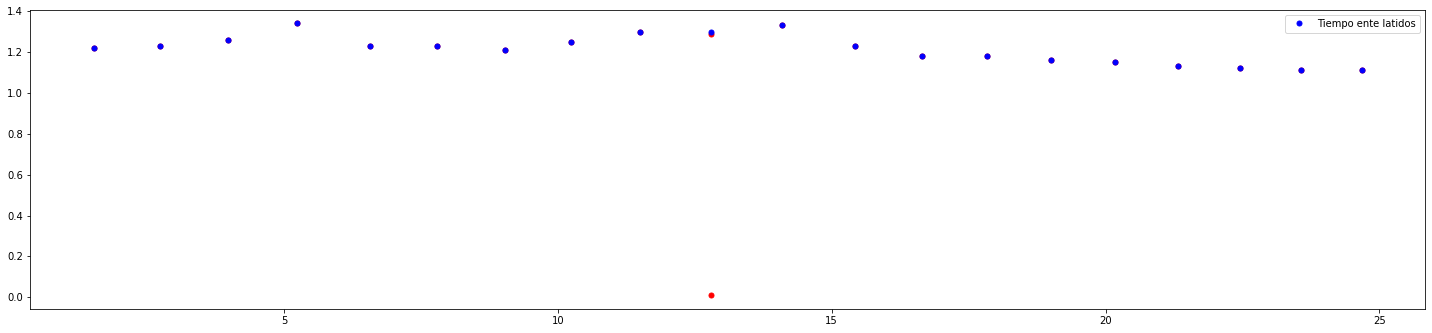

In [ ]:

difR=array = [(tiempo[tRsIndex[x]]-tiempo[tRsIndex[x-1]]) for x in range(1, len(tRsIndex))]
difRt=array = [tiempo[tRsIndex[x-1]] for x in range(1, len(tRsIndex))]
tRsIn=list(tRsIndex[:-1])
plt.plot(difRt,difR,'.',markersize = 10, color = 'r');

# Esta función se encarga de determinar si los BPM están 
# dentro del rango aceptable, para determinar si son mediciones 
# correctas o errores y deben ser eliminados.

x = 1
while x < len(difR):
  if difR[x-1]<60/200:
    difR[x]=difR[x]+difR[x-1]
    difR.pop(x-1)
    difRt.pop(x-1)
    tRsIn.pop(x-1)
  elif difR[x-1]>60/30:
    difR.pop(x-1)
    difRt.pop(x-1)
    tRsIn.pop(x-1)
  else:
    x += 1
  
plt.plot(difRt,difR,'.',markersize = 10, color = 'b',label='Tiempo ente latidos');
plt.legend()

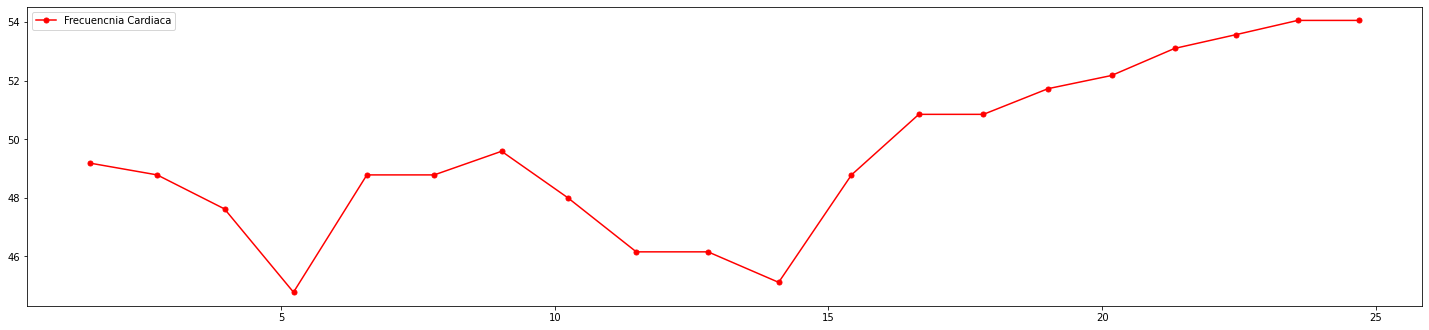

In [ ]:
plt.plot(difRt,60/np.array(difR),'.-',markersize = 10, color = 'r',label='Frecuencnia Cardiaca');
plt.legend()

##Calculo de los tiempos respecto de R.
Se procede a realizar los cálculos de los segmentos teniendo la lista de los R correctamente obtenidos.   
Esto permite tener al R como referencia base.

In [ ]:
# Se toman los valores de tiempo que corresponden a los puntos hallados 
#  los signos T y Q, Esto nos va a permitir hallar las diferencias para 
#  cada uno de los respectivos tiempos de R.
Ttimes=tfil1[tTsIndex]
Qtimes=tiempo[tiQsIndex]
Stimes=tiempo[tfSsIndex]
Tsegment=np.zeros(len(difRt))
Qsegment=np.zeros(len(difRt))
Ssegment=np.zeros(len(difRt))


# Se calcula la diferencia entre cada uno de los tiempos R y todos los 
# tiempos T, se calcula el valor absoluto y luego el mínimo de dicha lista.
# Rango aceptable, entre el 20% y el 40% del tiempo BPM.
for x in range(len(difRt)):
  minT=min(abs(Ttimes-difRt[x]))
  # print(minT,difR[x])
  if minT<=.4*difR[x] and minT>=.18*difR[x]:
    Tsegment[x]=minT
# Se calcula la diferencia entre cada uno de los tiempos R y todos los 
# tiempos Q, se calcula el valor absoluto y luego el mínimo de dicha lista.
# Rango aceptable, entre el 0% y el 12% del tiempo BPM.
for x in range(len(difRt)):
  minQ=min(abs(Qtimes-difRt[x]))
  # print(minQ,difR[x])
  if minQ<=.2*difR[x]:
    Qsegment[x]=minQ
for x in range(len(difRt)):
  minS=min(abs(Stimes-difRt[x]))
  # print(minS,difR[x])
  if minS<=.4*difR[x]:
    Ssegment[x]=minS

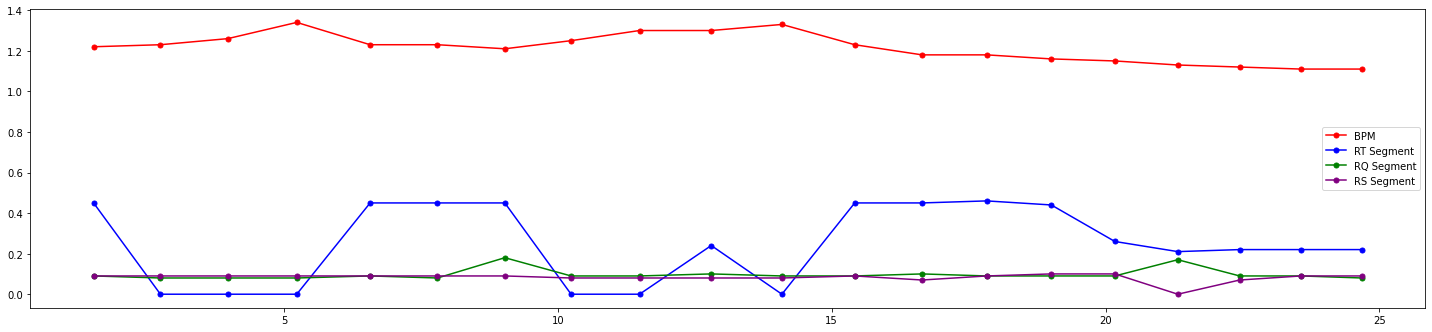

In [ ]:
plt.plot(difRt,difR,'.-',markersize = 10, color = 'r',label='BPM');
plt.plot(difRt,Tsegment,'.-',markersize = 10, color = 'b',label='RT Segment');
plt.plot(difRt,Qsegment,'.-',markersize = 10, color = 'g',label='RQ Segment');
plt.plot(difRt,Ssegment,'.-',markersize = 10, color = 'purple',label='RS Segment');
plt.legend()

#Conclusiones .
* Los sistemas de electrocardiograma médicos tiene un costo muy elevado, sin embargo, existen alternativas de bajo costo para proyectos académicos que nos permiten en módulos pequeños y configurables que nos permiten realizar lecturas básicas que nos permiten tener un acercamiento al análisis y tratamiento de señales de biopotenicales.
* Los módulos de electrocardiograma de bajo costo permiten obtener medidas de biopotenciales, sin embargo, estos presentan un alto nivel de ruido, lo que nos obliga a realizar un proceso de tratamiento de datos para poder realizar análisis sobre las señales obtenidas, esto implica procesos de filtrado.
* Gracias al bajo costo y gran distribución de microcontroladores y placas de adquisición de datos se facilita realizar tratamiento de señales en forma digital, lo que nos disminuye los requerimientos en montajes analógicos y de hardware, sin embargo esto implica algorines para el tratamiento de datos como filtros FIR, promedios , derivadas y más, estos implica conocimiento en tratamiento de señales y lenguajes de programación.
*El filtro promedio es simple y muy útil para conocer una aproximación muy buena de la forma real de la señal ECG a comparación de filtros FIR pasa bajos o pasa altos. Esto los hizo esenciales para 2 cosas en este proyecto:


1. Lograr identificar los puntos clave de la señal y de sus derivadas, ya que estas (en particular las últimas) tienen una alta dificultad para su tratamiento cuando se busca identificar una característica particular que permita la identificación de un punto de interés.

2. Retirar las variaciones de baja frecuencia y el nivel de DC de la señal, de manera que una señal que esta "montada" sobre una señal de ruido de baja frecuencia, se puede traer al nivel de cero, lo cual facilita su análisis
